In [1]:
%reset-f
%load_ext autoreload
%autoreload
%matplotlib inline

from pandas.io import wb
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm

import warnings
warnings.filterwarnings("always",category=UserWarning)
from res_ind_lib import *
import os, time
import itertools

from wb_api_wraper import *

In [2]:
#Number of simulations (1e3 starts being slow, 1e4 uses 4GB)
n=int(1e4)


# WB data

In [3]:
#population from WB
pop      =get_wb_mrv('SP.POP.TOTL'      ,"pop").squeeze()#population

In [4]:
#country dictionaries
iso_country = pd.read_csv("iso3_to_wb_name.csv", index_col = "iso3", squeeze=True)
name_wb_name = pd.read_csv("any_name_to_wb_name.csv",index_col="any",squeeze=True)

#population from landscan

In [5]:
#total pop from landscan
h=pd.read_csv("pop_landscan_0703.csv")
h.columns = h.columns.str.lower()
h["country"]=h.admin.replace(name_wb_name)
pop_landscan = h.rename(columns=dict(pylssum="pop")).dropna().set_index("country")["pop"] 

country
Aruba                             0.725556
Bahamas, The                      0.742040
Bahrain                           0.749171
Cyprus                            0.590476
Equatorial Guinea                 0.747002
Faeroe Islands                    0.718945
French Polynesia                  0.685429
Greenland                         0.303881
Kiribati                          0.244232
Kuwait                            0.756923
Maldives                          0.368121
Marshall Islands                  0.075798
Norway                            0.788198
Oman                              0.776241
Palau                             0.667109
Papua New Guinea                  0.794891
Samoa                             0.752063
Solomon Islands                   0.604055
Somalia                           0.694482
St. Kitts and Nevis               0.701637
St. Vincent and the Grenadines    0.666722
Tonga                             0.479628
Tuvalu                            0.070447
Uni

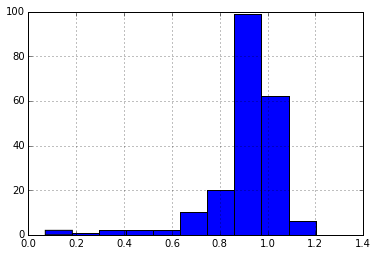

In [6]:
#compares population in landscn with population in WB
test=(pop_landscan/pop)
test.hist()
test[test<.8]

###data on exposure per bassin per country per hydro return period

In [7]:
#Reads and adapts chaging raw data to current code
translator ={'iso_a3':"country_iso", "fpu_id":"fpu_id", 'lssum':'fpu_population', 'py5sum':"5", 'py10sum':"10",
        'py25sum':"25",  'py50sum':"50",  'py100sum':"100", 'py250sum':"250",  'py500sum':"500",  'py1000sum':"1000",
        'admin':'name'}
#translates random column names to what i want to use
ebp=pd.read_csv("basins_0702_adrien.csv")
ebp.columns=ebp.columns.str.lower()
ebp =ebp.rename(columns=translator)[sorted(list(translator.values()))];

#ebp[ebp==0]=1e-6

ebp.head()


,10,100,1000,25,250,5,50,500,country_iso,fpu_id,fpu_population,name
0,0,0,0,0,0,0,0,0,AFG,20,472,Afghanistan
1,73400,105534,117383,102266,105828,34094,104100,116724,AFG,172,2791282,Afghanistan
2,461759,599214,680372,539858,635334,322025,565776,651817,AFG,188,7392882,Afghanistan
3,74,1364,4854,1243,4447,47,1364,4854,AFG,205,135807,Afghanistan
4,1798,2275,2905,1907,2499,1659,2256,2754,AFG,206,21637,Afghanistan


In [8]:
ebp["country"] = ebp.name.replace(name_wb_name)
print("Places ignored\n"+", ".join([str(c) for c in ebp.country.unique() if c not in iso_country.unique()]+list(ebp.ix[ebp.country.isnull()].name.unique())))
ebp= ebp.dropna()

Places ignored
Akrotiri Sovereign Base Area, nan, Baykonur Cosmodrome, Cura̤ao, Cyprus No Mans Area, Dhekelia Sovereign Base Area, Kosovo, Northern Cyprus, Palestine, São Tomé and Príncipe, Siachen Glacier, Somaliland, US Naval Base Guantanamo Bay, Aland, Falkland Islands, Gibraltar, Guernsey, Jersey, Montserrat, Saint Pierre and Miquelon, Vatican, Western Sahara


In [9]:
#return period and associated bins
col_names = {'5':5, '10':10, '25':25, '50':50, '100':100, '250':250, '500':500, '1000':1000}
p = sorted(list(col_names.values()))  #"probas" of each return period
p

[5, 10, 25, 50, 100, 250, 500, 1000]

In [10]:
#reshaping
expo_bassin = ebp.set_index(["country","fpu_id"]).drop(["country_iso","name"],axis=1).sortlevel().rename(columns=col_names)

#separates exposure and total population
pop_bassin_country = expo_bassin["fpu_population"]
expo_bassin = expo_bassin[p]

#Assumes nobody exposed under 5 years
expo_bassin[0]=0
expo_bassin.sort_index(axis=1,inplace=True)

#number of people exposed in each country,bassin
expo_bassin.head()


0       5       10      25      50      100     250   \
country     fpu_id                                                         
Afghanistan 20         0       0       0       0       0       0       0   
            172        0   34094   73400  102266  104100  105534  105828   
            188        0  322025  461759  539858  565776  599214  635334   
            205        0      47      74    1243    1364    1364    4447   
            206        0    1659    1798    1907    2256    2275    2499   

                      500     1000  
country     fpu_id                  
Afghanistan 20           0       0  
            172     116724  117383  
            188     651817  680372  
            205       4854    4854  
            206       2754    2905

Countries with missmatch between tot pop and bassin pop country
Aruba                       0.000021
St. Lucia                   0.525274
Turks and Caicos Islands    0.476926
Vanuatu                     0.892374
Virgin Islands, British     0.828344
dtype: float64


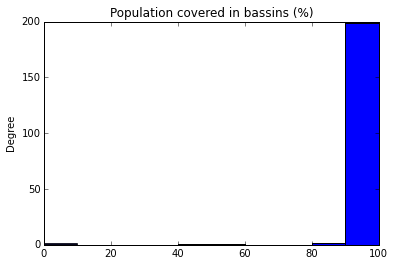

In [11]:
#Country population sanity check
check = (pop_bassin_country.sum(level="country")/pop_landscan)
(100*check).plot(kind="hist",title="Population covered in bassins (%)")
print("Countries with missmatch between tot pop and bassin pop",check[check<.9])
check.to_csv("pop_covered_bassins.csv")
del check

In [12]:
#Bassin population sanity check (same bassin should be different accross countries)
expo_bassin.reset_index().set_index("fpu_id").sort_index().head()

,country,0,5,10,25,50,100,250,500,1000
fpu_id,,,,,,,,,,
2,Greenland,0,0,0,0,0,0,0,0,0
3,Russian Federation,0,362,442,546,578,612,660,679,689
4,Russian Federation,0,3318,4469,5036,5462,5705,6047,6217,6458
5,Canada,0,2520,2556,3522,3862,4193,4193,4194,4856
5,United States,0,1364,1603,1674,1793,1804,1848,1918,1930


In [13]:
#fraction of people exposed in the bassin for each return period (NOT USED)
exp_bass_rel=expo_bassin.div(pop_bassin_country,axis=0)
expo_bassin.columns.name = "event"
exp_bass_rel.head()
del exp_bass_rel

In [14]:
#reshaping
exposures = expo_bassin.stack().reset_index().rename(columns={0:"nba"})
exposures.ix[20:24]

,country,fpu_id,event,nba
20,Afghanistan,188,10,461759
21,Afghanistan,188,25,539858
22,Afghanistan,188,50,565776
23,Afghanistan,188,100,599214
24,Afghanistan,188,250,635334


###Simulates events (mind memory usage from here)

This is ineficient in terms of memory usage. I should write a loop over countries, so i can use a fraction of the RAM 

In [15]:
#random dataframe X~1/Uniform([0,1])
alea = pd.DataFrame(columns=expo_bassin.index,index=range(0,n))
alea = pd.DataFrame( np.power(np.random.random(alea.shape),-1), columns=alea.columns,index=alea.index)
alea.index.name="sce"
alea.head()

#ugly reshaping
alea = alea.unstack().reset_index().rename(columns={0:"rand"})
alea.ix[20:24]

,country,fpu_id,sce,rand
20,Afghanistan,20,20,2.515598
21,Afghanistan,20,21,3.240040
22,Afghanistan,20,22,4.289606
23,Afghanistan,20,23,5.421904
24,Afghanistan,20,24,1.720842


In [16]:
#Disretizes events to closest documented event
bins = p.copy()
bins.insert(0,0)
bins.append(np.inf)
print(bins)

alea["event"] = pd.cut(alea.rand,bins,labels = bins[:-1])

alea.head()

[0, 5, 10, 25, 50, 100, 250, 500, 1000, inf]


,country,fpu_id,sce,rand,event
0,Afghanistan,20,0,1.277470,0
1,Afghanistan,20,1,1.266196,0
2,Afghanistan,20,2,1.698027,0
3,Afghanistan,20,3,6.889402,5
4,Afghanistan,20,4,2.584487,0


In [1]:
q

NameError: name 'q' is not defined

In [2]:
#sanity check: are return periods numerically matched? with n=1e3 error is  about 2% for rp=1000. 
#error is .1% with n=1e4
#at country scale the error is still less than .1%

#theory
q = [0]+[1-1/x for x in p]+[1]
q=np.diff(q)
print("theory",q)

#practice
counts = alea.ix[alea.country=="Sri Lanka"].event.value_counts()
print("\npractice\n",counts/counts.sum())

#relative error
print("\nrelative error (%)\n",100*np.abs(counts/counts.sum()-q)/q)

NameError: name 'p' is not defined

##Socio-economice exposure

In [18]:
#exposure per country, bassin, event (merges events and exposure for each event ) (WAY TOO LONG)
m = pd.merge(alea,exposures,on=["country","fpu_id","event"],how="left").set_index(["country","sce","fpu_id"]).sortlevel()
print("should read zero:",alea.shape[0]-m.shape[0])
#m.event.unique()

should read zero: 0


In [19]:
#summing afected people accross bassins and reshaping
nba=m["nba"].sum(level=["country","sce"]).unstack("country") #number of people exposed by sceneario 
nba["Sri Lanka"]

sce
0             0
1             0
2             0
3             0
4             0
5             0
6             0
7        973615
8       1189320
9             0
10            0
11            0
12      1062488
13            0
14            0
15       973615
16            0
17            0
18       973615
19            0
20      1062488
21            0
22      1189320
23            0
24            0
25            0
26            0
27            0
28            0
29            0
         ...   
9970          0
9971          0
9972    1062488
9973          0
9974          0
9975          0
9976          0
9977          0
9978          0
9979     973615
9980    1062488
9981     973615
9982          0
9983          0
9984          0
9985          0
9986          0
9987          0
9988    1189320
9989          0
9990          0
9991          0
9992          0
9993          0
9994          0
9995          0
9996          0
9997          0
9998          0
9999          0
Name: Sri Lanka, dty

In [20]:
#fraction of total population 
fa=nba.div(pop_landscan).dropna(how="all",axis=1)
#del nba
fa.head()

country,Afghanistan,Akrotiri Sovereign Base Area,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,...,Uruguay,Uzbekistan,Vanuatu,"Venezuela, RB",Vietnam,Virgin Islands (U.S.),"Virgin Islands, British","Yemen, Rep.",Zambia,Zimbabwe
sce,,,,,,,,,,,,,,,,,,,,,
0,0.000055,0,0.000000,0.000000,0,0.000090,0,5.232153e-05,0.016299,0,...,0,0.000000,0,0.008667,0.000770,0,0,0,0.000010,0.000000
1,0.000000,0,0.000000,0.027099,0,0.001803,0,0.000000e+00,0.000000,0,...,0,0.018397,0,0.009147,0.159078,0,0,0,0.000799,0.000000
2,0.010591,0,0.000000,0.002699,0,0.000428,0,2.882475e-02,0.016299,0,...,0,0.000000,0,0.000082,0.037763,0,0,0,0.009383,0.001102
3,0.000000,0,0.000000,0.000013,0,0.000698,0,2.370708e-08,0.029823,0,...,0,0.001659,0,0.031938,0.000000,0,0,0,0.000866,0.000967
4,0.019843,0,0.044164,0.000000,0,0.002323,0,1.696621e-03,0.000000,0,...,0,0.003154,0,0.026130,0.001838,0,0,0,0.013266,0.000135


In [21]:
#using quantiles to compute return periods
quant = [1-1/x for x in p]
quant[0]=0.799 #works around numerical bug with only one bassin
print("Quantiles:" ,quant)
result = fa.quantile(quant).transpose().dropna()
#del fa
result.columns = p
result.ix["Sri Lanka"]

Quantiles: [0.799, 0.9, 0.96, 0.98, 0.99, 0.996, 0.998, 0.999]


5       0.045849
10      0.050035
25      0.050035
50      0.059714
100     0.062331
250     0.062341
500     0.064987
1000    0.067517
Name: Sri Lanka, dtype: float64

In [22]:
result[result==0].dropna(how="all")

,5,10,25,50,100,250,500,1000
country,,,,,,,,
Akrotiri Sovereign Base Area,0,0,0,0,0,0,0,0
Antigua and Barbuda,0,0,0,0,0,0,0,0
Aruba,0,0,0,0,0,0,0,0
"Bahamas, The",0,0,0,0,0,0,0,0
Bahrain,0,0,0,0,0,0,0,0
Barbados,0,0,0,0,0,0,0,0
Bhutan,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brunei Darussalam,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Comoros,0,0,0,0,0,0,0,0


In [23]:
result.to_csv("exposure_econ_return_period.csv",encoding="utf-8")

###Comparing with previous, erroneous, method

,0,5,10,25,50,100,250,500,1000
country,,,,,,,,,
Bhutan,,,,1,,1.039436,1.037815,1.037815,
Croatia,,,,,1.104714,1.059221,,,
Portugal,,,,1,,,,,
Taiwan,,,1,,,,,,


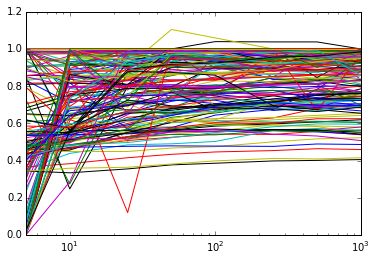

In [24]:
compare = (result/expo_bassin.sum(level="country").div(pop_landscan,axis=0))
compare.transpose().plot(legend=None, logx=True)
compare[compare>1].dropna(how="all").fillna(" ")